# Apple vs. Oranges Dataset Preparation  
Dataset is obtained from [Fruit-360](https://github.com/Horea94/Fruit-Images-Dataset) Dataset.  

## Plot Apples and Oranges Photos  

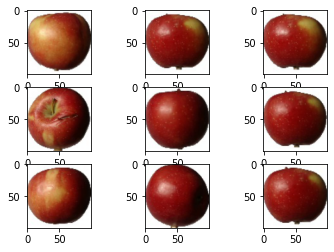

In [1]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
from os import listdir

# define location of dataset
path = '/home/walee/Documents/apples-vs-oranges'

# plot first few images
for i, j in enumerate(listdir(path+'/train/Apple')[:9]):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = path + '/train/Apple/' + j
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

We can update the example and change it to plot cat photos instead; the complete example is listed below.

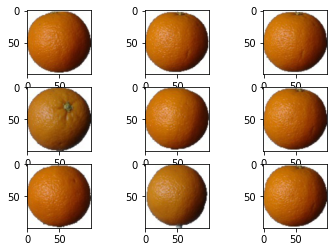

In [2]:
# plot first few images
for i, j in enumerate(listdir(path+'/train/Orange')[:9]):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = path + '/train/Orange/' + j
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

# Develop a Baseline CNN Model  
In this section, we can develop a baseline convolutional neural network model for the dogs vs. cats dataset.  
  
A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.  
  
A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper [“Very Deep Convolutional Networks for Large-Scale Image Recognition.”](https://arxiv.org/abs/1409.1556)  
  
The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.  
  
We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.  
  
Each layer will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:  

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Next, we need to prepare the data.

This involves first defining an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

Next, iterators need to be prepared for both the train and test datasets.  
  
We can use the flow_from_directory() function on the data generator and create one iterator for each of the train/ and test/ directories. We must specify that the problem is a binary classification problem via the “class_mode” argument, and to load the images with the size of 200×200 pixels via the “target_size” argument. We will fix the batch size at 64.  

In [5]:
# prepare iterators
train_it = datagen.flow_from_directory(path+'/train', class_mode='binary', batch_size=64, target_size=(50, 50))
test_it = datagen.flow_from_directory(path+'/test', class_mode='binary', batch_size=64, target_size=(50, 50))

Found 971 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


We can then fit the model using the train iterator (train_it) and use the test iterator (test_it) as a validation dataset during training.  
  
The number of steps for the train and test iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and test directories divided by the batch size (64).  
  
The model will be fit for 20 epochs, a small number to check if the model can learn the problem.  

In [6]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)

/home/walee/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Once fit, the final model can be evaluated on the test dataset directly and the classification accuracy reported.

In [7]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

/home/walee/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 87.346


Finally, we can create a plot of the history collected during training stored in the “history” directory returned from the call to fit_generator().  
  
The History contains the model accuracy and loss on the test and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.  
  
The summarize_diagnostics() function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.  

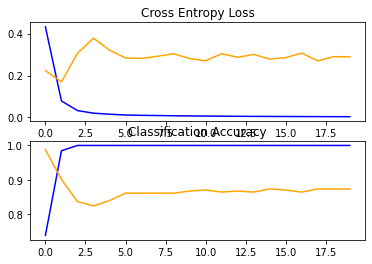

In [8]:
import sys
from matplotlib import pyplot

# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + '_plot.png')
pyplot.show()
pyplot.close()

## Save Final Model
We are now ready to fit a final model on the entire training dataset.  
  
The flow_from_directory() must be updated to load all of the images from the new finalize_dogs_vs_cats/ directory.  

In [9]:
train_it.class_indices

{'Apple': 0, 'Orange': 1}

Once fit, we can save the final model to an H5 file by calling the save() function on the model and pass in the chosen filename.

In [10]:
# save model
model.save('apple-vs-orange.h5')

## Make Prediction
We can use our saved model to make a prediction on new images.  
  
The model assumes that new images are color and they have been segmented so that one image contains at least one dog or cat.  
  
Below is an image extracted from the test dataset for the dogs and cats competition. It has no label, but we can clearly tell it is a photo of a dog. You can save it in your current working directory with the filename ‘sample_image.jpg‘.  
  
<img src=https://www.applesfromny.com/wp-content/uploads/2020/05/Jonagold_NYAS-Apples2.png width=300 />
  
  
* [Download Apple Photograph (sample_image.jpg)](https://www.applesfromny.com/wp-content/uploads/2020/05/Jonagold_NYAS-Apples2.png)  
  
We will pretend this is an entirely new and unseen image, prepared in the required way, and see how we might use our saved model to predict the integer that the image represents. For this example, we expect class “1” for “Dog“.  
  
**Note**: the subdirectories of images, one for each class, are loaded by the flow_from_directory() function in alphabetical order and assigned an integer for each class. The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: cat=0, dog=1. This can be changed via the “classes” argument in calling flow_from_directory() when training the model.  
  
First, we can load the image and force it to the size to be 224×224 pixels. The loaded image can then be resized to have a single sample in a dataset. The pixel values must also be centered to match the way that the data was prepared during the training of the model. The load_image() function implements this and will return the loaded image ready for classification.  

In [13]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# load and prepare the image
filename = 'sample_image.png'
# load the image
img = load_img(filename, target_size=(50, 50))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
img = img.reshape(1, 50, 50, 3)
# center pixel data
img = img.astype('float32')
img = img - [123.68, 116.779, 103.939]

/home/walee/anaconda3/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Next, we can load the model as in the previous section and call the predict() function to predict the content in the image as a number between “0” and “1” for “cat” and “dog” respectively.

In [14]:
# predict the class
from tensorflow.keras.models import load_model

model = load_model('apple-vs-orange.h5')

result = model.predict(img)

In [15]:
result

array([[0.]], dtype=float32)

# References
[How to Classify Photos of Dogs and Cats (with 97% accuracy)](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)